### CPS_PECERT_Mapper

February 1, 2019

Brian Dew @bd_econ

Map what share of each state's population has a professional certification.


In [1]:
# Import packages 
import pandas as pd
import numpy as np
import os
os.environ['PROJ_LIB'] = '/home/brian/miniconda3/share/proj'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap as Basemap
# Settings for the map

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
# Weighted average
def wavg(group):
    d = group[group['CERT']==1].BASICWGT.sum()
    w = group.BASICWGT.sum()
    return (d / w) * 100

In [3]:
# Retrieve professional certification rate by state
columns = ['MONTH', 'STATE', 'CERT', 'BASICWGT']
s = (pd.read_feather('cps2018.ft', columns=columns)
       .query('MONTH > 7')
       .append(pd.read_feather('cps2019.ft', columns=columns))
       .query('CERT in [0, 1]')
       .groupby('STATE')
       .apply(wavg))

In [4]:
# Convert state two letter abbreviations to state names
os.chdir('/home/brian/Documents/econ_data/micro/')
states = (pd.read_csv('shapefiles/states.csv')
            .set_index('Abbreviation')
            .to_dict()['State'])
s.index = s.index.map(states)

In [5]:
# Map values to colors
vmax, vmin = s.max(), s.min()
cm = plt.cm.summer
state_colors = {}
for state, val in s.to_dict().items():
    state_colors[state] = cm(1.-np.sqrt((val-vmin)/(vmax-vmin)))[:3]

/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


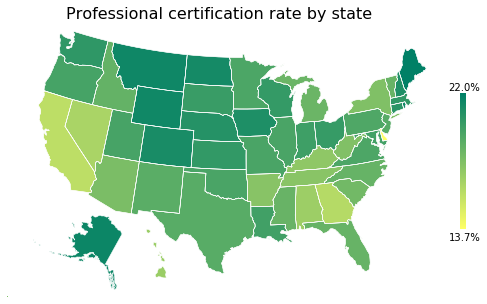

In [15]:
# Create map
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

fig = plt.figure(figsize=(10, 5))

# Read the shapefile contained in the same folder (and the two related files)
m.readshapefile('shapefiles/states', 'states', 
                drawbounds=True, color='#ffffff')
ax = plt.gca()
ax.axis('off')

for info, shape in zip(m.states_info, m.states):
    if info['STATE_NAME'] in ['Alaska', 'Hawaii']:
        # Only include the 8 main islands of Hawaii 
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(i[0] + 5200000, i[1] - 1400000) for i in shape]
        # Alaska is large. Rescale it.
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(i[0]*0.35 + 1100000, i[1]*0.35 -1300000) for i in shape]
    poly = Polygon(shape, facecolor=state_colors[info['STATE_NAME']], 
                    edgecolor='#ffffff', linewidth=.5)
    ax.add_patch(poly)


plt.title('Professional certification rate by state', fontsize=16)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
imshow = plt.imshow(gradient, cmap=plt.get_cmap('summer_r'))
cb = fig.colorbar(imshow, shrink=0.5)
cb.outline.set_visible(False)
cb.set_ticks([])
plt.text(5250000, 2450000, f'{round(s.max(), 1)}%')
plt.text(5250000, 660000, f'{round(s.min(), 1)}%')
plt.show()